In [13]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import seaborn as sns
pd.set_option('display.max_colwidth', -1)
import re
import json
from sklearn.model_selection import train_test_split

# Humicroedit and Funlines

In [3]:
data_main = pd.read_csv('data/humicroedit/task_1_all/train.csv')
data_funlines = pd.read_csv('data/humicroedit/task_1_all/train_funlines.csv')
humi = pd.concat([data_main, data_funlines])
humi = humi.drop_duplicates()
humi['len'] = [len(i.split(' ')) for i in humi['original']]
humi.head(2)

,id,original,edit,grades,meanGrade,len
0,14530,France is ‘ hunting down its citizens who joined <Isis/> ’ without trial in Iraq,twins,10000,0.2,15
1,13034,"Pentagon claims 2,000 % increase in Russian trolls after <Syria/> strikes . What does that mean ?",bowling,33110,1.6,17


Reviews are judged by variable number of people, and humor is subjective. We want to have some measure of how sure we are in the judgements. Paper notes that each headline had 5 judges.

In [4]:
grades = humi.grades.astype(str).str.split('')
std_list = np.zeros(len(grades))
for i,g in enumerate(grades):
    g = g[1:][:-1]
    g = list(map(int, g))
    std_list[i] = np.std(g)
humi['score_std'] = std_list

Text(0, 0.5, 'Standard deviation')

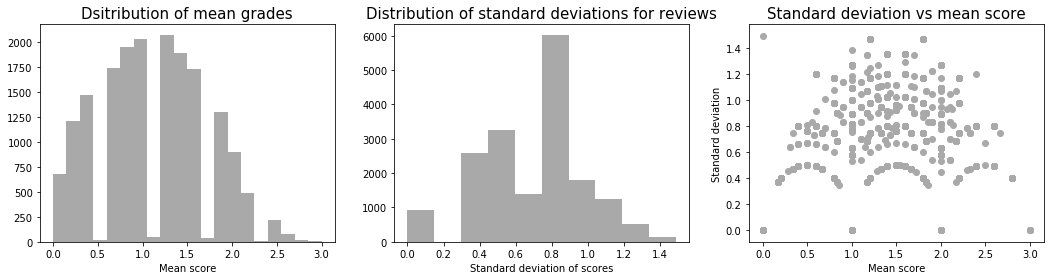

In [37]:
fig, axs = plt.subplots(1, 3, figsize = (18,4))
axs[0].hist(humi.meanGrade, bins=20, color='darkgrey')
axs[0].set_title('Dsitribution of mean grades', size = 15)
axs[0].set_xlabel('Mean score')
axs[1].hist(humi.score_std, color='darkgrey')
axs[1].set_title('Distribution of standard deviations for reviews', size = 15)
axs[1].set_xlabel('Standard deviation of scores')
axs[2].scatter(humi.meanGrade, humi.score_std, color='darkgrey')
axs[2].set_title('Standard deviation vs mean score', size = 15)
axs[2].set_xlabel('Mean score')
axs[2].set_ylabel('Standard deviation')

The most dissagreement is on the "medium funny jokes", in the range from 1 to 2. Let's look at some eaxmples of jokes with 0 scores, jokes in 1-2 range and mean above 2.5

In [234]:
humi[humi.meanGrade==0].head(3)

,id,original,edit,grades,meanGrade,len,score_std
4,6164,Trump was told weeks ago that Flynn misled <Vice/> President .,school,0,0.0,11,0.0
9,14191,Dutch minister resigns in drug baron <row/>,blow,0,0.0,8,0.0
46,11660,Jared Kushner is the Real <President/>,Enemy,0,0.0,7,0.0


In [235]:
humi[humi.meanGrade==1].head(5)

,id,original,edit,grades,meanGrade,len,score_std
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor Crashes <Coalition/>,party,22100,1.0,11,0.894427
7,3731,"As Someone Who Grew Up Among Fundamentalist <Christians/> In The US , I 'm Surprised Anyone 's Surprised About Roy Moore",morons,21110,1.0,21,0.632456
10,14268,Dozens dead in possible gas <attack/> in Syria ; regime denies allegation,bloating,22100,1.0,12,0.894427
12,7614,Trump 's 2nd Nominee for <Army/> Secretary Withdraws,Class,22100,1.0,8,0.894427
21,1415,Russian Trolls Would Love the ' Honest <Ads/> Act ',hotdogs,21110,1.0,10,0.632456


In [236]:
humi[humi.meanGrade==3].head(5)

,id,original,edit,grades,meanGrade,len,score_std
1490,3404,"President Trump 's first year <anniversary/> report card , with grades from A + to F",Kindergarten,33333,3.0,16,0.0
6075,1229,Recent Scandals Highlight Trump 's Chaotic <Management/> Style,Fashion,33333,3.0,8,0.0
419,100419,Stormy Daniels on testifying to Congress : ' I have no fear of being under <oath/> ',politicians,33333,3.0,17,0.0
5115,105115,Sanders Says He Has More <Donors/> Than Trump,hair,33333,3.0,8,0.0


### Are hair jokes more funny? Are Trump jokes more funny?

Text(0.5, 0, 'mean score')

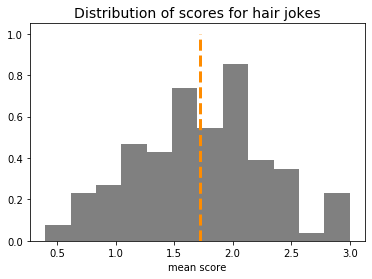

In [244]:
hair = humi[humi.edit.str.lower()=='hair'][['original', 'edit','meanGrade', 'score_std']]
plt.hist(hair.meanGrade, color='grey', bins=12, density=True)
plt.vlines(hair.meanGrade.mean(), ymin=0, ymax=1, color='darkorange', lw=3, ls='--')
plt.title('Distribution of scores for hair jokes', size=14)
plt.xlabel('mean score')

Text(0.5, 0, 'mean score')

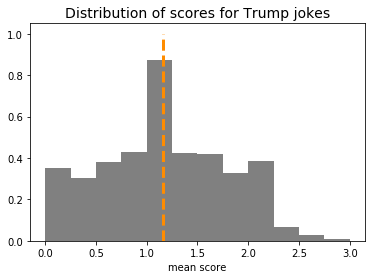

In [241]:
trump = humi[[('trump' in i) for i in humi.original.str.lower()]][['original', 'edit', 'meanGrade', 'score_std']]
plt.hist(trump.meanGrade, color='grey', bins=12, density=True)
plt.vlines(trump.meanGrade.mean(), ymin=0, ymax=1, color='darkorange', lw=3, ls='--')
plt.title('Distribution of scores for Trump jokes', size=14)
plt.xlabel('mean score')

# Hashtag wars

In [107]:
hashtag_files_dir = 'data/hashtag_wars/train_dir/train_data/'
hashtag_files = os.listdir(hashtag_files_dir)
for i,f in enumerate(hashtag_files):
    try: 
        temp = pd.read_csv(hashtag_files_dir+f, sep='\t', header=None)
        temp['topic'] = f[:-4]
    except: pass
    if i==0: hashtag = temp
    else: hashtag = pd.concat([hashtag, temp], sort=False)

In [109]:
hashtag.columns = ['id', 'raw_text', 'score', 'topic']
hashtag.head(2)

,id,raw_text,score,topic
0,746395385170649088,Tony Hawk's Pro Mater #RuinAVideoGame @midnight,0,Ruin_A_Video_Game
1,746403973498822658,"@midnight @burnie @GavinFree @bdunkelman ""Silent Hills"" #RuinAVideoGame #FuckYouKonami",0,Ruin_A_Video_Game


In [110]:
#remove mentions and hashtags
hashtag['text'] = [' '.join(word for word in i.split(' ') if not (word.startswith('#') or word.startswith('@'))) for i in hashtag['raw_text']]

In [112]:
hashtag.head(2)

,id,raw_text,score,topic,text
0,746395385170649088,Tony Hawk's Pro Mater #RuinAVideoGame @midnight,0,Ruin_A_Video_Game,Tony Hawk's Pro Mater
1,746403973498822658,"@midnight @burnie @GavinFree @bdunkelman ""Silent Hills"" #RuinAVideoGame #FuckYouKonami",0,Ruin_A_Video_Game,"""Silent Hills"""


In [116]:
hashtag[hashtag.score==2]

,id,raw_text,score,topic,text
111,746183823784878081,@Midnight #PointsMe #RuinAVideoGame Halo by @Adele,2,Ruin_A_Video_Game,Halo by
103,712119303743516673,Voices in head made manifest #TwitterIn5Words @midnight,2,Twitter_In_5_Words,Voices in head made manifest
130,709589126274637825,Hubblegum #ScienceFoods @midnight,2,Science_Foods,Hubblegum
137,667201717956706304,Dat Ash Wednesday #SexyHolidays @midnight,2,Sexy_Holidays,Dat Ash Wednesday
79,653775535429038080,What exactly do you plan to do about joke theft on Twitter? @midnight #BetterDebateQuestions,2,Better_Debate_Questions,What exactly do you plan to do about joke theft on Twitter?
108,750549276737110017,#GotFiredBecause balls deep is not an acceptable answer when asked about my works progress. @midnight,2,Got_Fired_Because,balls deep is not an acceptable answer when asked about my works progress.
98,667576678223212544,"Still don't have kids, mom. @midnight #ThanksgivingIn5Words #PointsMe",2,Thanksgiving_In_5_Words,"Still don't have kids, mom."
18,649791075574530048,Andrew Slice Clay @midnight #Pizzalebrities,2,Pizzalebrities,Andrew Slice Clay
20,664545282881884161,#ScienceABook The Unbearable Lightness of Helium @midnight,2,Science_A_Book,The Unbearable Lightness of Helium
72,743284691390857216,Can't Touch This Thermostat #DadSongs @midnight,2,Dad_Songs,Can't Touch This Thermostat


Might not be very applicable as without topic they are not funny at all

# Crowdtruth

In [118]:
oneliners = pickle.load(open('data/crowdtruth/datasets/humorous_oneliners.pickle', 'rb'))

In [125]:
oneliners_len = [len(i.split(' ')) for i in oneliners]

In [120]:
oneliners[0:10]

['Insanity is hereditary, - You get it from your children.',
 'An honest politician is one who, when bought, stays bought.',
 "You can tune a piano, but you can't tuna fish.",
 'A closed mouth gathers no foot.',
 "What's black and white and red all over?  An embarassed zebra.",
 "What's black and white and red all over?  Certainly not the Halifax newspapers.",
 "Gravity doesn't exist: the earth sucks.",
 "What's the most popular form of birth control?  The headache.",
 "He who laughs last probably doesn't understand the joke.",
 'Let him who takes the plunge remember to return it by Tuesday.']

# Short jokes

In [285]:
short = pd.read_csv('data/short_jokes/shortjokes.csv')
short['len'] = [len(i.split(' ')) for i in short['Joke']]
short = short.drop('ID', axis=1)
short.head()

,Joke,len
0,"[me narrating a documentary about narrators] ""I can't hear what they're saying cuz I'm talking""",15
1,"Telling my daughter garlic is good for you. Good immune system and keeps pests away.Ticks, mosquitos, vampires... men.",18
2,I've been going through a really rough period at work this week It's my own fault for swapping my tampax for sand paper.,23
3,"If I could have dinner with anyone, dead or alive... ...I would choose alive. -B.J. Novak-",16
4,Two guys walk into a bar. The third guy ducks.,10


# Joke dataset

In [179]:
wocka = json.load((open('data/joke_dataset/wocka.json')))
wocka_oneliners = [i['body'] for i in wocka if (i['category']=='One Liners')]
len(wocka_oneliners)

917

In [ ]:
stupid = json.load((open('data/joke_dataset/stupidstuff.json')))
stupid_oneliners_dict = [i for i in stupid if (i['category']=='One Liners')]
len(stupid_oneliners_dict)

Not a very good resource, not enough, and generally low quality

# Puns dataset (train)
From Reddit Humor detection. Use only train for easier comparison w/ existing methods

In [191]:
puns = pd.read_csv('data/reddithumordetection/data/puns/train.tsv', header=None)
puns = puns[[1, 3]]
puns.columns = ['score', 'text']
puns['len'] = [len(i.split(' ')) for i in puns.text]
puns.head(2)

,score,text,len
0,0,I m hoping they ll come and see this and say We have to have this,16
1,1,a man who cannot read the sign that warns people from throwing garbage on the ground is illiterate,18
2,1,i fired the floor refinishers they simply could not hold their lacquer,12
3,1,an elevator makes ghosts happy because it lifts the spirits,10
4,1,the first drinking establishment in alaska was a polar bar,10


In [190]:
puns.score.value_counts()

0    1810
1    1809
Name: score, dtype: int64

# Light comparison of the datasets

In [192]:
numberjokes = pd.DataFrame({
    'dataset': ['Humicroedit + Funlines', 'Short jokes', 'Crowdtruth', 'Puns'],
    'n_samples': [humi.shape[0], short.shape[0], len(oneliners_len), puns.shape[0]]
})
numberjokes

,dataset,n_samples
0,Humicroedit + Funlines,17900
1,Short jokes,231657
2,Crowdtruth,5251
3,Puns,3619


Text(0.5, 1.0, 'Number of samples in each dataset')

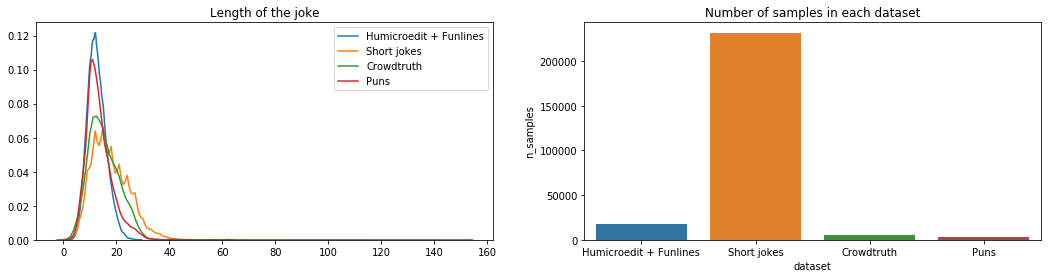

In [194]:
fig, axs = plt.subplots(1, 2, figsize = (18,4))
sns.kdeplot(humi['len'], label='Humicroedit + Funlines', ax=axs[0])
sns.kdeplot(short['len'], label='Short jokes', ax=axs[0])
sns.kdeplot(oneliners_len, label='Crowdtruth', ax=axs[0])
sns.kdeplot(puns['len'], label='Puns', ax=axs[0])
sns.barplot(x="dataset", y="n_samples", data=numberjokes, ax=axs[1])
axs[0].set_title('Length of the joke')
axs[1].set_title('Number of samples in each dataset')

## Balancing with not-jokes datasets

### Crowdtruth data

In [300]:
proverbs = pickle.load(open('data/crowdtruth/datasets/proverbs.pickle', 'rb'))
proverbs_df = pd.DataFrame({
    'text': proverbs,
    'len': [len(i.split(' ')) for i in proverbs],
    'basic_score': np.zeros(len(proverbs))
})
reuters = pickle.load(open('data/crowdtruth/datasets/reuters_headlines.pickle', 'rb'))
reuters_df = pd.DataFrame({
    'text': reuters,
    'len': [len(i.split(' ')) for i in reuters],
    'basic_score': np.zeros(len(reuters))
})
wiki = pickle.load(open('data/crowdtruth/datasets/wiki_sentences.pickle', 'rb'), encoding='latin1')
wiki_df = pd.DataFrame({
    'text': wiki,
    'len': [len(i.split(' ')) for i in wiki],
    'basic_score': np.zeros(len(wiki))
})

In [301]:
not_joke_len = pd.DataFrame({
    'dataset': ['Proverbs', 'Reuters headlines', 'Wiki sentences'],
    'n_samples': [proverbs_df.shape[0], reuters_df.shape[0], wiki_df.shape[0]]
})
not_joke_len

,dataset,n_samples
0,Proverbs,1019
1,Reuters headlines,5243
2,Wiki sentences,5251


Text(0.5, 1.0, 'Number of samples in each dataset')

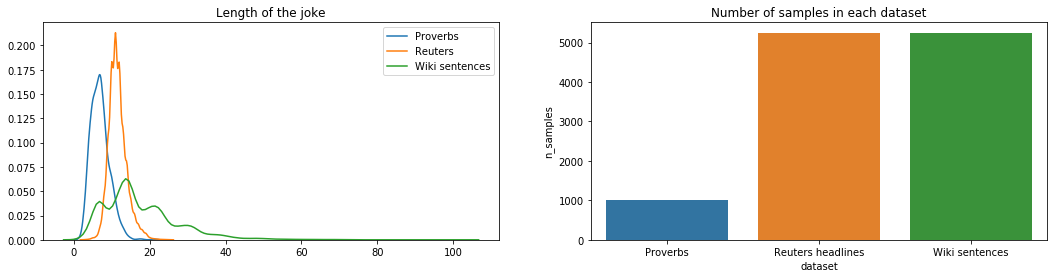

In [302]:
fig, axs = plt.subplots(1, 2, figsize = (18,4))
sns.kdeplot(proverbs_df['len'], label='Proverbs', ax=axs[0])
sns.kdeplot(reuters_df['len'], label='Reuters', ax=axs[0])
sns.kdeplot(wiki_df['len'], label='Wiki sentences', ax=axs[0])
sns.barplot(x="dataset", y="n_samples", data=not_joke_len, ax=axs[1])
axs[0].set_title('Length of the joke')
axs[1].set_title('Number of samples in each dataset')

### Million news

# Dataset options

1. *basic* All together, with binary labels. For Humicroedit use only 'funny' versions. For balance add some news titles and/or quotes

2. *basic-weighted* All together, with added pre-set weights to funny jokes based on the dataset it was taken from. For Humicroedit use only 'funny' versions. For balance add some news titles and/or quotes

3. *humicroedit* Use only humicroedit, only original and replaced

4. *basic expanded* All together, humicroedit both funny and not, shuffled

## Humicroedit+FunLines

In [6]:
#humicroedit and funlines
humi['text'] = [full_processing(row) for i,row in humi.iterrows()]
humi['basic_score'] = [int(i>1.5) for i in humi.meanGrade]
humi.head(2)

,id,original,edit,grades,meanGrade,len,score_std,text,basic_score
0,14530,France is ‘ hunting down its citizens who joined <Isis/> ’ without trial in Iraq,twins,10000,0.2,15,0.4,France is ‘ hunting down its citizens who joined twins ’ without trial in Iraq,0
1,13034,"Pentagon claims 2,000 % increase in Russian trolls after <Syria/> strikes . What does that mean ?",bowling,33110,1.6,17,1.2,"Pentagon claims 2,000 % increase in Russian trolls after bowling strikes . What does that mean ?",1


In [7]:
original_list = [drop_replacement_symbols(i) for i in humi.original]
len(original_list)

17900

In [14]:
humi_jokes = humi[['text', 'meanGrade', 'score_std', 'basic_score']]
humi_orig = pd.DataFrame({
    'text': original_list,
    'meanGrade': np.zeros(len(original_list)),
    'score_std': np.zeros(len(original_list)),
    'basic_score': np.zeros(len(original_list))
})
humi_orig = humi_orig.drop_duplicates()
humi_dataset = pd.concat([humi_jokes, humi_orig], sort=False)
humi_dataset['scaled_mean'] = humi_dataset.meanGrade/3
humi_dataset = humi_dataset.sample(frac=1).reset_index(drop=True) #shuffle
#humi_dataset['text'] = humi_dataset['text'].astype('|S')
humi_dataset.head(2)

,text,meanGrade,score_std,basic_score,scaled_mean
0,5 jugglers of Iran-backed militia killed in Iraq airstrike | CBC News,0.8,0.748331,0.0,0.266667
1,Undocumented donkeys Arrested While Seeking Protective Order Faces 10 Years In Prison,1.4,1.356466,0.0,0.466667


In [9]:
humi_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29321 entries, 0 to 29320
Data columns (total 5 columns):
text           29321 non-null object
meanGrade      29321 non-null float64
score_std      29321 non-null float64
basic_score    29321 non-null float64
scaled_mean    29321 non-null float64
dtypes: float64(4), object(1)
memory usage: 1.1+ MB


In [11]:
humi_dataset.to_csv('data/created_datasets/humicroedit_unpaired.csv', index=False)

In [15]:
train, valid = train_test_split(humi_dataset, test_size=0.25)
train.to_csv('data/created_datasets/humicroedit_unpaired_train.csv', index=False)
valid.to_csv('data/created_datasets/humicroedit_unpaired_valid.csv', index=False)

In [12]:
print('Percent funny jokes:', humi_dataset.basic_score.sum()/humi_dataset.shape[0])

Percent funny jokes: 0.1609767743255687


Obvious that just using basic score would be a bad idea, not enough "very funny" jokes

## Basic

In [5]:
"""
Functions for the Humicroedit/Funlines editing
"""
def replace_word(sentence, new_word):
    return re.sub('<(.*?)/>', new_word, sentence)

def drop_replacement_symbols(sentence):
    sentence = sentence.replace('<', '')
    return sentence.replace('/>', '')

def full_processing(row):
    return drop_replacement_symbols(replace_word(row.original, row.edit))

In [286]:
# JOKES
#humicroedit and funlines
humi['text'] = [full_processing(row) for i,row in humi.iterrows()]
humi['basic_score'] = [int(i>1.5) for i in humi.meanGrade]
#oneliners crowdtruth
oneliners_df = pd.DataFrame({'text': oneliners, 'basic_score': np.zeros(len(oneliners))+1})
#short jokes
short.columns = ['text', 'len']
short['basic_score'] = np.zeros(short.shape[0])+1
# puns
puns.columns = ['basic_score', 'text', 'len']
# collect basic jokes dataset
columns_used = ['text', 'basic_score']
basic_full = pd.concat([humi[columns_used], oneliners_df[columns_used], short[columns_used], puns[columns_used]])
basic_full = basic_full.sample(frac=1).reset_index(drop=True)
basic_full.head(2)

,text,basic_score
0,How do you make a hormone? You pay her. (This was told at my pharmacy school. We laughed and then felt shame afterwards.),1.0
1,"According to Einstein's theory of relativity, Chuck Norris can actually roundhouse kick you yesterday.",1.0


In [287]:
print('Fraction funny samples:',basic_full.basic_score.sum()/basic_full.shape[0])

Fraction funny samples: 0.9419952249571446


In [276]:
# BALANCE - not jokes, use Crowdtruth



,text,basic_score
0,"Margot Robbie's Harley Quinn, playing with her puddin' Oops. I thought I was searching redtube. Sorry 'bout that.",1.0
1,Menendez Bribe Case Proceeds After Judge Rejects check,0.0


In [279]:
print('Fraction funny samples:',basic_full.basic_score.sum()/basic_full.shape[0])

Fraction funny samples: 0.9419952249571446


In [275]:
basic_full.to_csv('data/created_datasets/basic_full.csv', index=False)

In [ ]:
# create splits for train and validation
from sklearn.model_selection import train_test_split
train_basic, valid_basic = train_test_split(basic_full, test_size=0.2)